#Лабораторна робота №3. Boosting

**Виконала** студентка групи КІ-41мп Додонова Марія.

**Мета:** Ознайомлення із бустінгом - одним з підвидів ансамблевого навчання. Розуміти застосування бустінгу та вплив типу машинного навчання на ефективність бустінгу. Порівняння беггінгу та бустінгу.


##Порядок виконання

1. В ході виконання роботи буде досліджено ефективність та особливості застосування бустінгу для побудови ансамблей для задачі класифікації. Вам необхідно використати щонайменше **2** типи слабких класифікаторів. Слабкі класифікатори обирати на свій розсуд, наприклад багатошаровий персептрон, опроно-векторні машини, дерева рішень тощо.
2. Обрати набір данних. Використовувати рекомендується  низькорозмірні набори зображень (mnist / fashion mnist).
3. Обрати методологію бустінгу(**adaboost / xgboost / gradient boost / catboost**)
4. Навчити слабкі класифікатори та їх ансамблеві варіанти. Всього в роботі необхідно буде дослідити **пʼять моделей** (див. Таблицю 1). Кількість класифікаторів та їх співвідношення (як і гіперпараметри моделі) - на ваш розсуд.
5. Заповнити таблицю 1 отриманими значеннями. Також рекомендється додати скріншоти метрик навчання у протокол.
6. Оформити отримані результати у протоколі.


Таблиця 1

| Модель                                     | Boosting | Average Accuracy <br> (test) | Average Accuracy <br> (validation) | Average Precision <br> (validation) | F1 score |
|--------------------------------------------|----------|-------------------------|------------------------------|--------------------------------|---------|
| Слабкий Класифікатор 1                     | xgboost  |                         |                              |                                |         |
| Анамбль (Слабкий Класифікатор 1)           | xgboost  |                         |                              |                                |         |
| Слабкий Класифікатор 2                     | xgboost  |                         |                              |                                |         |
| Анамбль (Слабкий Класифікатор 2)           | xgboost  |                         |                              |                                |         |
| Анамбль (Слабкий Класифікатор 1 <br> + Слабкий Класифікатор 2) | xgboost  |                         |                              |                                |         |


##Виконання роботи

Імпортуємо необхідні модулі та встановимо значення SEED для відтворюваності результатів. Оберемо низькорозмірний набір зображень MNIST. Завантажимо його та виконаємо попередню обробку даних. Розділимо набір на три частини: тренувальну, валідаційну та тестову вибірки.

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from sklearn.utils import check_random_state
import numpy as np
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
random_state = check_random_state(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Define transformations for MNIST (convert to tensor and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1))
])

# Load MNIST dataset
train_data = MNIST(
    root="./data", train=True, transform=transform, download=True)
test_data = MNIST(
    root="./data", train=False, transform=transform, download=True)

# Split MNIST into training (90%) and validation (10%) sets
train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

# Create DataLoaders for MNIST dataset
train_loader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)
val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

Перетворимо дані у масиви NumPy.

In [ ]:
def loader_to_numpy(loader):
    X, y = [], []
    for features, labels in loader:
        X.append(features.numpy())
        y.append(labels.numpy())
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

X_train, y_train = loader_to_numpy(train_loader)
X_val, y_val = loader_to_numpy(val_loader)
X_test, y_test = loader_to_numpy(test_loader)

Створимо структуру для зберігання метрик Average Accuracy (test), Average Accuracy (validation), Average Precision (validation) та F1-score усіх моделей.

In [ ]:
table_data = {
    "Модель": [
        "MLP", "Анамбль (MLP)",
        "Decision Tree", "Анамбль (Decision Tree)",
        "Анамбль (MLP + Decision Tree)"
    ],
    "Boosting": ["adaboost"] * 5,
    "Average Accuracy (test)": [None] * 5,
    "Average Accuracy (validation)": [None] * 5,
    "Average Precision (validation)": [None] * 5,
    "F1 score": [None] * 5
}

Оберемо 2 слабкі класифікатори: дерево рішень та багатошаровий персептрон. Багатошаровий персептрон матиме 3 приховані шари та приховані активації ReLU.


In [ ]:
from sklearn.tree import DecisionTreeClassifier
import torch.nn as nn

class MLP(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size):
    super(MLP, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(input_size, hidden_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[1], output_size)
    )

  def forward(self, x):
    return self.layers(x)

Напишемо функції для тренування та валідації багатошарового персептрона протягом однієї епохи. Обчислюватимемо в кожній метрику Accuracy.

In [ ]:
def train(model, optimizer, criterion, loader):
  model.train()
  correct, total = 0, 0

  for features, labels in loader:
    optimizer.zero_grad()
    outputs = model(features)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  accuracy = correct / total
  return accuracy

def validate(model, loader):
  model.eval()
  correct, total = 0, 0

  with torch.no_grad():
    for features, labels in loader:
      outputs = model(features)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = correct / total
  return accuracy

Також напишемо функцію для побудови графіка історії тренування багатошарових персептронів у ансамблі.

In [ ]:
import matplotlib.pyplot as plt

def plot_histories(train_histories, val_histories,
                   title="Ensemble MLP Training Progress"):
  plt.figure(figsize=(12, 6))
  colors = ["b", "g", "r", "c", "m", "y", "k", "orange", "lime", "purple"]

  for i in range(len(train_histories)):
    label = f"MLP {i}"
    color = colors[i % len(colors)]
    plt.plot(train_histories[i], linestyle="-", color=color,
             label=f"MLP {i+1} (train)")
    plt.plot(val_histories[i], linestyle="--", color=color,
             label=f"MLP {i+1} (val)")

  plt.xlabel("Epochs")
  plt.ylabel(f"Accuracy Value")
  plt.title(title)

  num_epochs = len(train_histories[0])
  tick_positions = np.arange(0, num_epochs, step=max(1, num_epochs // 10))
  tick_labels = [str(i+1) for i in tick_positions]
  plt.xticks(tick_positions, tick_labels)

  plt.legend(loc="best", fontsize=8)
  plt.grid(True)

  plt.show()

Визначимо клас ансамблю Бустингу. За замовчуванням, використовується 5 дерев рішень та 5 багатошарових персептронів із прихованими шарами розмірів 128 та 64. Для навчання персептронів використовується 15 епох, оптимізатор Adam, швидкість навчання 0.001 та функція втрат CrossEntropyLoss. Максимальна глибина дерева рішень - 7.  Оберемо методологію бустінгу adaboost.  
Оцінювання ансамблю проводитимемо за метриками accuracy, precision та f1-score.

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, f1_score

class BoostingEnsemble:
  def __init__(self, num_dt=5, num_mlp=5, mlp_input_size=784,
               mlp_hidden_sizes=[128, 64], mlp_output_size=10,
               mlp_num_epochs=15, dt_max_depth=7, learning_rate=0.001):
    self.num_dt = num_dt
    self.dt_max_depth = dt_max_depth
    self.num_mlp = num_mlp
    self.mlp_input_size = mlp_input_size
    self.mlp_hidden_sizes = mlp_hidden_sizes
    self.mlp_output_size = mlp_output_size
    self.mlp_num_epochs = mlp_num_epochs
    self.learning_rate = learning_rate
    self.models = []
    self.alphas = []
    self.mlp_train_histories = []
    self.mlp_val_histories = []

  def __train_mlp(self, X, y, sample_weights, val_loader):
    mlp = MLP(
        self.mlp_input_size, self.mlp_hidden_sizes, self.mlp_output_size
    )
    criterion = nn.CrossEntropyLoss(reduction="none")
    optimizer = optim.Adam(mlp.parameters(), lr=self.learning_rate)

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    weights_tensor = torch.tensor(sample_weights, dtype=torch.float32)
    train_history, val_history = [], []

    for epoch in range(self.mlp_num_epochs):
      # Train part
      mlp.train()
      optimizer.zero_grad()
      outputs = mlp(X_tensor)
      losses = criterion(outputs, y_tensor)
      weighted_losses = torch.mean(losses * weights_tensor)
      weighted_losses.backward()
      optimizer.step()

      _, predicted = torch.max(outputs, 1)
      total = len(y)
      correct = (predicted == y).sum().item()
      train_accuracy = correct / total
      train_history.append(train_accuracy)

      # Validation part
      val_accuracy = validate(mlp, val_loader)
      val_history.append(val_accuracy)

    return mlp, predicted, train_history, val_history

  def __train_tree(self, X, y, sample_weights):
    dt = DecisionTreeClassifier(max_depth=self.dt_max_depth)
    dt.fit(X, y, sample_weight=sample_weights)
    predicted = dt.predict(X)
    return dt, predicted

  def fit(self, X_train, y_train, val_loader):
    N = len(y_train)
    weights = np.ones(N) / N

    for i in range(self.num_mlp + self.num_dt):
      if i >= self.num_mlp:
        model, predictions = self.__train_tree(X_train, y_train, weights)
      else:
        model, predictions, train_history, val_history = \
        self.__train_mlp(X_train, y_train, weights, val_loader)
        predictions = predictions.detach().numpy()
        self.mlp_train_histories.append(train_history)
        self.mlp_val_histories.append(val_history)

      error = np.sum(weights * (predictions != y_train)) / np.sum(weights)
      if error == 0:
        continue

      alpha = 0.5 * np.log((1 - error) / error)
      weights *= np.exp(-alpha * (2 * (predictions == y_train) - 1))
      weights /= np.sum(weights)

      self.models.append(model)
      self.alphas.append(alpha)

  def predict(self, X_test):
    final_predictions = np.zeros((len(X_test), self.mlp_output_size))

    for model, alpha in zip(self.models, self.alphas):
      if isinstance(model, MLP):
        model.eval()
        with torch.no_grad():
          X_tensor = torch.tensor(X_test, dtype=torch.float32)
          outputs = model(X_tensor)
          probs = torch.nn.functional.softmax(outputs, dim=1)
          logits = probs.detach().cpu().numpy()
      else:
        logits = np.zeros((len(X_test), self.mlp_output_size))
        predictions = model.predict(X_test)
        for i, p in enumerate(predictions):
          logits[i, p] = 1.0

      final_predictions += alpha * logits

    return np.argmax(final_predictions, axis=1)

  def evaluate(self, X_test, y_test, X_val, y_val):
    y_pred_test = self.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    y_pred_val = self.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_precision = precision_score(y_val, y_pred_val, average="macro",
                                    zero_division=0)
    val_f1 = f1_score(y_val, y_pred_val, average="macro", zero_division=0)

    result = {
        "Average Accuracy (test)": test_accuracy,
        "Average Accuracy (validation)": val_accuracy,
        "Average Precision (validation)": val_precision,
        "F1 score": val_f1
    }

    return result

Навчимо слабкі класифікатори та їх ансамблеві варіанти. Спершу виконаємо навчання слабкого класифікатора - дерева рішень.

In [ ]:
dt = DecisionTreeClassifier(max_depth=7, random_state=SEED)
dt.fit(X_train, y_train)

y_val_pred = dt.predict(X_val)
y_test_pred = dt.predict(X_test)

dt_test_accuracy = accuracy_score(y_test, y_test_pred)
dt_val_accuracy = accuracy_score(y_val, y_val_pred)
dt_val_precision = precision_score(y_val, y_val_pred,
                                   average="macro", zero_division=0)
dt_f1_score = f1_score(y_val, y_val_pred, average="macro",
                       zero_division=0)

table_data["Average Accuracy (test)"][2] = dt_test_accuracy
table_data["Average Accuracy (validation)"][2] = dt_val_accuracy
table_data["Average Precision (validation)"][2] = dt_val_precision
table_data["F1 score"][2] = dt_f1_score

print("Decision Tree Classifier Metrics")
print(f" Test Accuracy: {dt_test_accuracy:.4f}")
print(f" Val Accuracy: {dt_val_accuracy:.4f}")
print(f" Val Precision: {dt_val_precision:.4f}")
print(f" F1-score: {dt_f1_score:.4f}")

Decision Tree Classifier Metrics
 Test Accuracy: 0.7922
 Val Accuracy: 0.7770
 Val Precision: 0.7784
 F1-score: 0.7753


Проведемо навчання слабкого класифікатора - багатошарового персептрона.

Multilayer Perceptron Metrics
 Test Accuracy: 0.8237
 Val Accuracy: 0.8155
 Val Precision: 0.8174
 F1-score: 0.8064


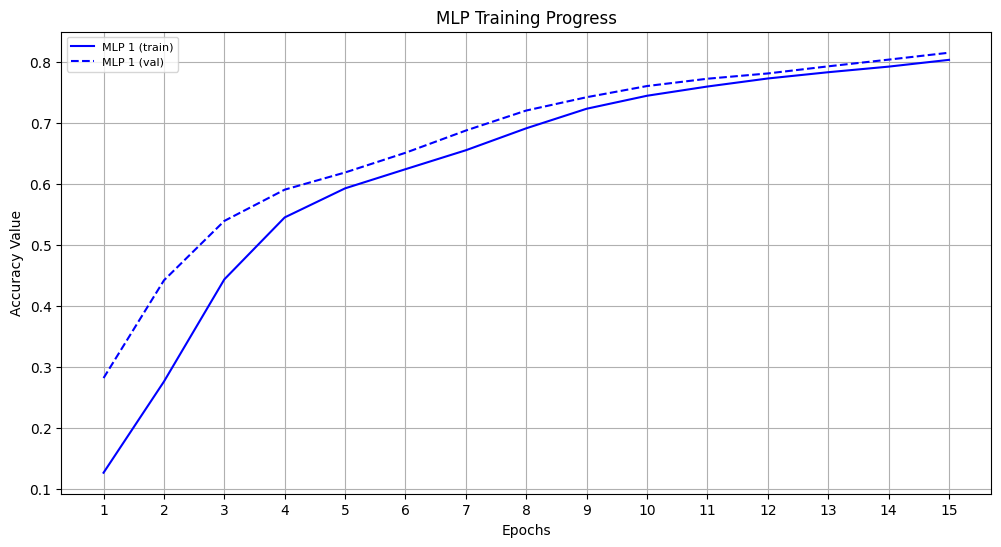

In [ ]:
train_history, val_history = [], []

mlp = MLP(28*28, [128, 64], 10)
optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(15):
  train_accuracy = train(mlp, optimizer, criterion, train_loader)
  val_accuracy = validate(mlp, val_loader)

  train_history.append(train_accuracy)
  val_history.append(val_accuracy)

y_val_pred = mlp(torch.tensor(X_val, dtype=torch.float32))
y_val_pred = y_val_pred.argmax(dim=1).numpy()

y_test_pred = mlp(torch.tensor(X_test, dtype=torch.float32))
y_test_pred = y_test_pred.argmax(dim=1).numpy()

mlp_test_accuracy = accuracy_score(y_test, y_test_pred)
mlp_val_accuracy = accuracy_score(y_val, y_val_pred)
mlp_val_precision = precision_score(y_val, y_val_pred,
                                    average="macro", zero_division=0)
mlp_f1_score = f1_score(y_val, y_val_pred, average="macro",
                        zero_division=0)

table_data["Average Accuracy (test)"][0] = mlp_test_accuracy
table_data["Average Accuracy (validation)"][0] = mlp_val_accuracy
table_data["Average Precision (validation)"][0] = mlp_val_precision
table_data["F1 score"][0] = mlp_f1_score

print("Multilayer Perceptron Metrics")
print(f" Test Accuracy: {mlp_test_accuracy:.4f}")
print(f" Val Accuracy: {mlp_val_accuracy:.4f}")
print(f" Val Precision: {mlp_val_precision:.4f}")
print(f" F1-score: {mlp_f1_score:.4f}")

plot_histories([train_history], [val_history],
               title="MLP Training Progress")

Проведемо навчання ансамблю з 10 багатошарових персептронів.

Ensemble (MLP) Metrics
 Test Accuracy: 0.8556
 Val Accuracy: 0.8423
 Val Precision: 0.8437
 F1-score: 0.8396


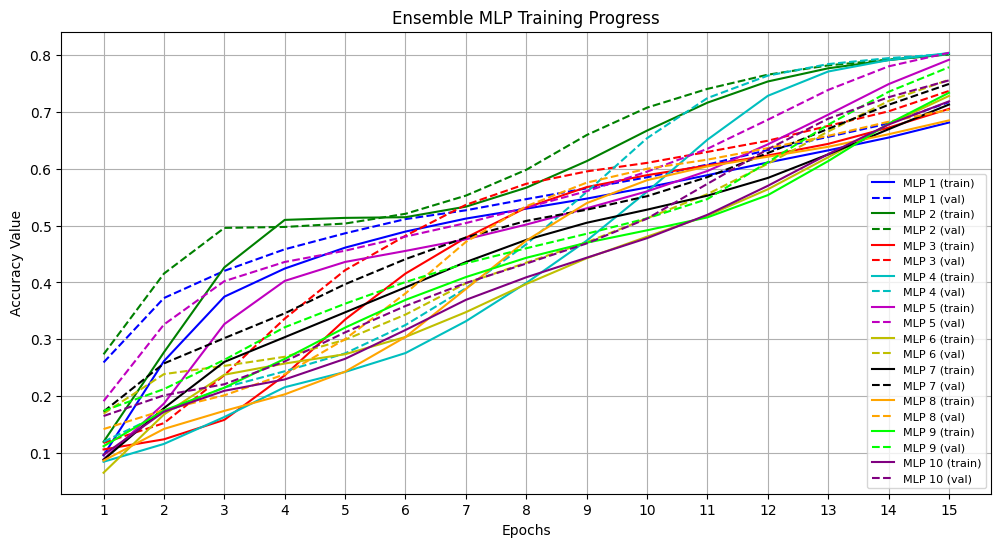

In [ ]:
ensemble_mlp = BoostingEnsemble(num_dt=0, num_mlp=10)
ensemble_mlp.fit(X_train, y_train, val_loader)
results = ensemble_mlp.evaluate(X_test, y_test, X_val, y_val)

table_data["Average Accuracy (test)"][1] = results["Average Accuracy (test)"]
table_data["Average Accuracy (validation)"][1] = results["Average Accuracy (validation)"]
table_data["Average Precision (validation)"][1] = results["Average Precision (validation)"]
table_data["F1 score"][1] = results["F1 score"]

print("Ensemble (MLP) Metrics")
print(f" Test Accuracy: {results['Average Accuracy (test)']:.4f}")
print(f" Val Accuracy: {results['Average Accuracy (validation)']:.4f}")
print(f" Val Precision: {results['Average Precision (validation)']:.4f}")
print(f" F1-score: {results['F1 score']:.4f}")

plot_histories(ensemble_mlp.mlp_train_histories,
               ensemble_mlp.mlp_val_histories)

Проведемо навчання ансамблю з 10 дерев рішень.

In [ ]:
ensemble_dt = BoostingEnsemble(num_mlp=0, num_dt=10)
ensemble_dt.fit(X_train, y_train, val_loader)
results = ensemble_dt.evaluate(X_test, y_test, X_val, y_val)

table_data["Average Accuracy (test)"][3] = results["Average Accuracy (test)"]
table_data["Average Accuracy (validation)"][3] = results["Average Accuracy (validation)"]
table_data["Average Precision (validation)"][3] = results["Average Precision (validation)"]
table_data["F1 score"][3] = results["F1 score"]

print("Ensemble (DT) Metrics")
print(f" Test Accuracy: {results['Average Accuracy (test)']:.4f}")
print(f" Val Accuracy: {results['Average Accuracy (validation)']:.4f}")
print(f" Val Precision: {results['Average Precision (validation)']:.4f}")
print(f" F1-score: {results['F1 score']:.4f}")

Ensemble (DT) Metrics
 Test Accuracy: 0.8893
 Val Accuracy: 0.8773
 Val Precision: 0.8764
 F1-score: 0.8757


Проведемо навчання ансамблю з 5 багатошарових персептронів та 5 дерев рішень.

Ensemble (MLP + DT) Metrics
 Test Accuracy: 0.9147
 Val Accuracy: 0.9040
 Val Precision: 0.9026
 F1-score: 0.9024


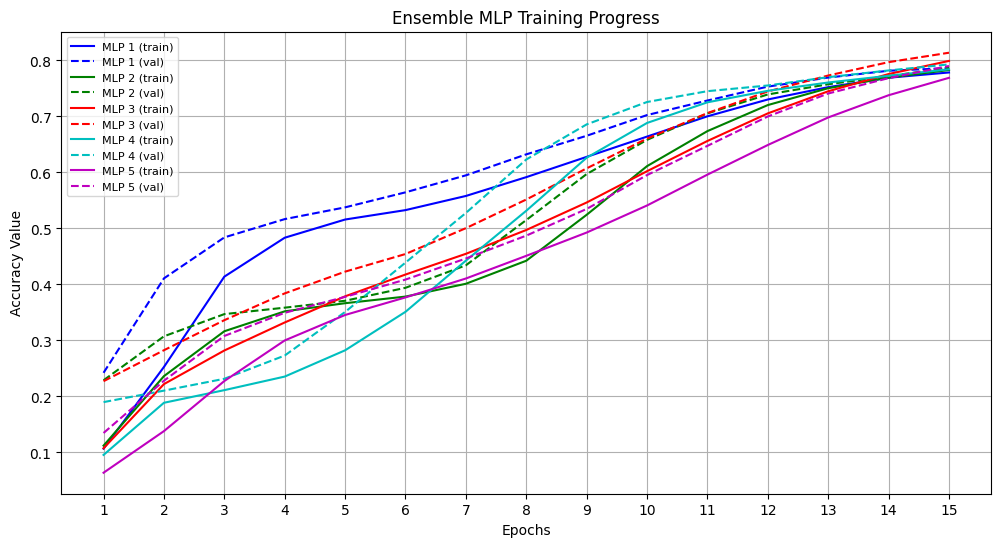

In [ ]:
ensemble_mlp_dt = BoostingEnsemble()
ensemble_mlp_dt.fit(X_train, y_train, val_loader)
results = ensemble_mlp_dt.evaluate(X_test, y_test, X_val, y_val)

table_data["Average Accuracy (test)"][4] = results["Average Accuracy (test)"]
table_data["Average Accuracy (validation)"][4] = results["Average Accuracy (validation)"]
table_data["Average Precision (validation)"][4] = results["Average Precision (validation)"]
table_data["F1 score"][4] = results["F1 score"]

print("Ensemble (MLP + DT) Metrics")
print(f" Test Accuracy: {results['Average Accuracy (test)']:.4f}")
print(f" Val Accuracy: {results['Average Accuracy (validation)']:.4f}")
print(f" Val Precision: {results['Average Precision (validation)']:.4f}")
print(f" F1-score: {results['F1 score']:.4f}")

plot_histories(ensemble_mlp_dt.mlp_train_histories,
               ensemble_mlp_dt.mlp_val_histories)

Заповнимо таблицю 1 отриманими значеннями.

In [ ]:
import pandas as pd
df = pd.DataFrame(table_data)
df

,Модель,Boosting,Average Accuracy (test),Average Accuracy (validation),Average Precision (validation),F1 score
0,MLP,adaboost,0.8237,0.815500,0.817442,0.806360
1,Анамбль (MLP),adaboost,0.8556,0.842333,0.843737,0.839642
2,Decision Tree,adaboost,0.7922,0.777000,0.778369,0.775254
3,Анамбль (Decision Tree),adaboost,0.8893,0.877333,0.876361,0.875716
4,Анамбль (MLP + Decision Tree),adaboost,0.9147,0.904000,0.902642,0.902437


Слабкий класифікатор дерево рішень з максимальною глибиною 7 демонструє високі значення точності на тестовому наборі, а його точність на валідаційній вибірці не значно відрізняється від тестової, що вказує на відсутність перенавчання.

Ансамбль з 10 дерев рішень показав дуже хороші результати, що значно вищими порівняно з окремими деревами. Це вказує на те, що комбінування декількох моделей допомогло зменшити варіативність у результатах, пов’язану з обмеженнями окремих дерев.

Для слабкого класифікатора багатошарового персептрона результат є значно кращим порівняно з деревом рішень. Графік історії навчання, який показує поступове зростання точності без перенавчання, вказує на ефективне навчання моделі. Після 7 епох точність зростає більш плавно, що може свідчити про те, що модель наближається до свого оптимуму.

Ансамбль з 10 персептронів значно покращує результати порівняно з окремими персептронами. Графік точностей демонструє, що перенавчання не спостерігається, а точність окремих персептронів коливається від 0.68 до 0.81.

Результати ансамблю, що поєднує 5 персептронів і 5 дерев рішень, свідчать про ще більше покращення, порівняно з використанням лише одного типу класифікатора у ансамблі. Використання комбінації персептронів і дерев рішень дозволяє компенсувати слабкості окремих моделей і зменшити ймовірність помилок, що виникають у кожній з них окремо. Таке комбінування, ймовірно, дає більш узагальнені моделі, що працюють краще на нових, не бачених даних.

Загалом, результати лабораторної роботи демонструють, що комбінування різних слабких класифікаторів у вигляді ансамблів може значно покращити точність моделі. Персептрони показали високу ефективність, особливо при використанні в ансамблях, а дерева рішень добре доповнили результати. Найкращі результати були досягнуті за допомогою ансамблю з 5 персептронів і 5 дерев рішень, що показало значне покращення точності, а також здатність до узагальнення на нових даних.

##Висновок

У ході виконання лабораторної роботи було досліджено метод бустингу з використанням різних слабких класифікаторів, зокрема дерев рішень і багатошарових персептронів для задачі класифікації на датасеті MNIST. Було побудовано ансамблі моделей, що складаються з персептронів, дерев рішень та їх комбінацій, а також проведено аналіз результатів навчання та тестування.

Найкращу точність на тестовому наборі (0.9147) продемонстрував ансамбль з 5 персептронів і 5 дерев рішень, де дерева рішень були треновані після персептронів. Це свідчить про успішне поєднання переваг обох типів класифікаторів, що дозволило досягти високої точності та хороших узагальнень.

Порівняно з окремими моделями, ансамблі показали значне покращення результатів. Наприклад, ансамбль з 10 дерев рішень досяг точності 0.8893, а ансамбль з 10 персептронів - 0.8556, що підтверджує перевагу ансамблів для задач класифікації через здатність знижувати помилки окремих моделей. Найгірші результати мали моделі з окремими слабкими класифікаторами.

Загалом, результати підтвердили ефективність методу бустингу в поєднанні з різними типами класифікаторів для задачі класифікації на MNIST, зокрема через використання ансамблів, що покращують стабільність та точність моделі.